W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
No valid ngrok token set — Spark UI won't be exposed externally.
Spark version: 3.5.1


Could not create ngrok tunnel (ok if no token or blocked): ngrok client exception, API returned 502: {"error_code":103,"status_code":502,"msg":"failed to start tunnel","details":{"err":"failed to start tunnel: Your account may not run more than 5 endpoints over a single ngrok agent session.\nThe endpoints already running on this session are:\ntn_36HXFnLKCOU6V8XZxm2V4CZWF8O, tn_36HYMflREPyRTjuRF96HDZUYCCq, tn_36HYRFnOmaLQgKuBNFqhZGsMeys, tn_36HYeRGc3kyFM4moszqoqeo8K6s, tn_36HYss1LiDz6if7iGq2tbkAT4z4.\nUpgrade to a Pay-as-you-go plan at: https://dashboard.ngrok.com/billing/choose-a-plan?plan=paygo\r\n\r\nERR_NGROK_324\r\n"}}

Schema preview:
root
 |-- ProductName: string (nullable = true)
 |-- ProductPrice: string (nullable = true)
 |-- Discount: string (nullable = true)
 |-- NumberofReviews: string (nullable = true)
 |-- Rate: string (nullable = true)
 |-- Review: string (nullable = true)
 |-- Summary: string (nullable = true)

Sample rows:
+--------------+-------------------+--------+-

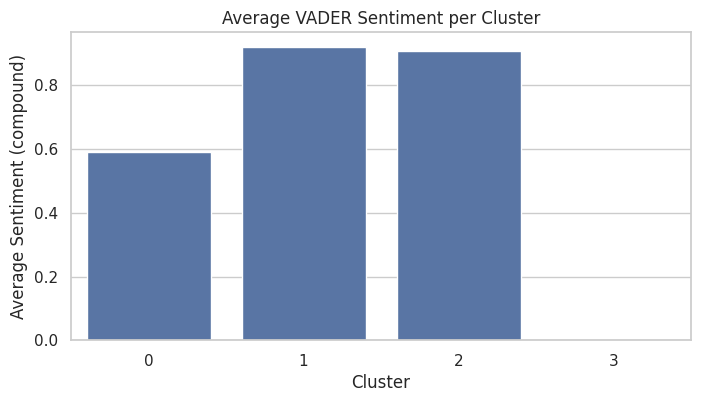

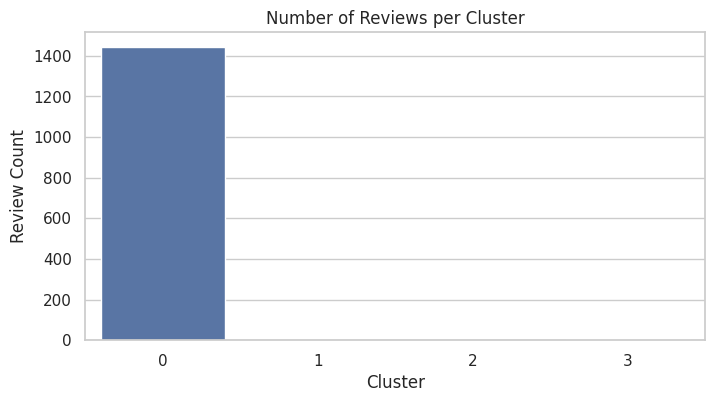

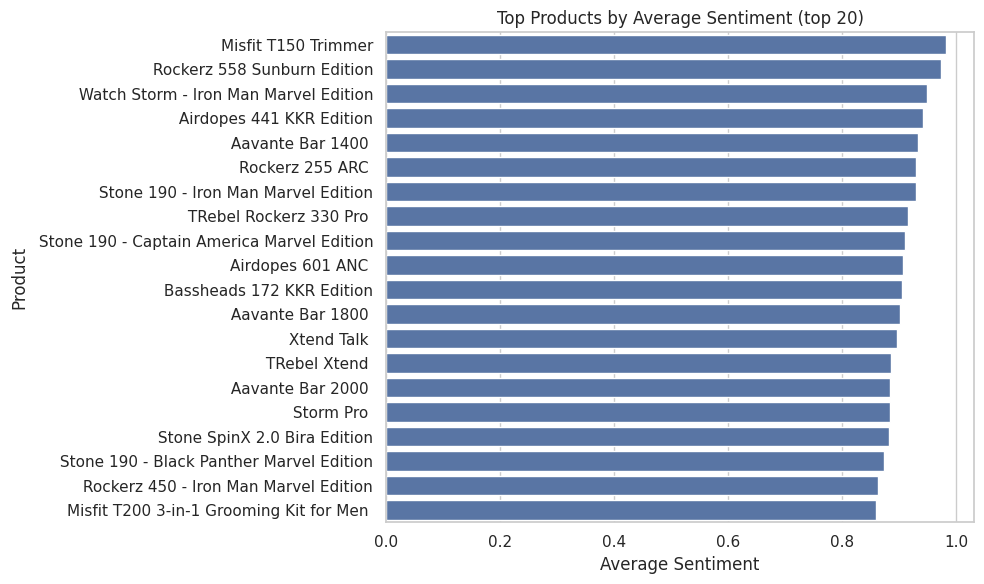

Sample reviews grouped by cluster (up to 5 per cluster):

--- Cluster 0 sample reviews ---
+--------------+----------------------------------------------------------------------------------+---------------+
|   ProductName|                                                              review_text_combined|sentiment_score|
+--------------+----------------------------------------------------------------------------------+---------------+
| Stone 1000v2 |                        Very good product in this price range... Fantastic product|         0.7778|
| Stone 1000v2 |                                                  Outstanding Product. Outstanding|         0.8402|
| Stone 1000v2 |Works like a charm. Good sound quality. Visually more attractive than v1.. Awesome|         0.9371|
| Stone 1000v2 |                                                         Great. Boat stone 1000 v2|         0.6249|
| Stone 1000v2 |                Amazing sound quality.totally premium.&.affordable.. Quality soun

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Done. Results saved as boat_clustered_reviews.csv


In [ ]:
# Colab cell: Product Review Sentiment Analysis (adapted for /mnt/data/BoatProduct.csv)
# Paste entire block into one Colab cell and run.

# ---------------------------
# 0. Install dependencies
# ---------------------------
!apt-get update -qq
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!pip install -q pyspark pyngrok pandas matplotlib seaborn vaderSentiment

# ---------------------------
# 1. ngrok token (optional)
# ---------------------------
from pyngrok import ngrok
NGROK_AUTH_TOKEN = "REPLACE_WITH_YOUR_NGROK_AUTHTOKEN"  # <-- replace this if you want public Spark UI
if NGROK_AUTH_TOKEN and "REPLACE_WITH" not in NGROK_AUTH_TOKEN:
    try:
        ngrok.set_auth_token(NGROK_AUTH_TOKEN)
        print("ngrok auth token set.")
    except Exception as e:
        print("ngrok token error:", e)
else:
    print("No valid ngrok token set — Spark UI won't be exposed externally.")

# ---------------------------
# 2. Start Spark session
# ---------------------------
from pyspark.sql import SparkSession
spark = (
    SparkSession.builder
    .appName("BoatProduct_Review_Sentiment")
    .config("spark.sql.shuffle.partitions", "2")
    .config("spark.ui.port", "4040")
    .getOrCreate()
)
sc = spark.sparkContext
print("Spark version:", spark.version)

# Expose Spark UI via ngrok (port 4040) - may fail if token invalid or blocked
try:
    public_url = ngrok.connect(addr="4040", proto="http")
    print("Spark Web UI (ngrok):", public_url)
except Exception as e:
    print("Could not create ngrok tunnel (ok if no token or blocked):", e)

# ---------------------------
# 3. Read dataset from mounted path (no upload required)
# ---------------------------
csv_path = "BoatProduct.csv"
df = (
    spark.read.option("header", "true")
    .option("inferSchema", "true")
    .option("quote", "\"") # Added: Specify the quote character
    .option("multiLine", "true") # Added: Handle multi-line records
    .csv(csv_path)
)
print("Schema preview:")
df.printSchema()
print("Sample rows:")
df.show(5, truncate=120)

# ---------------------------
# 4. Column mapping & create combined review text
# ---------------------------
# Detected columns: ProductName, ProductPrice, Discount, NumberofReviews, Rate, Review, Summary
REVIEW_COL = "Review"
SUMMARY_COL = "Summary"
PRODUCT_COL = "ProductName"
RATING_COL = "Rate"   # if this is numeric-like (e.g., 4.5) it will be used

from pyspark.sql.functions import coalesce, concat_ws, col, when
from pyspark.sql.types import DoubleType

# Create a combined text column (Summary + Review) to improve sentiment signals
df = df.withColumn("review_text_combined", concat_ws(". ", coalesce(col(SUMMARY_COL), col(REVIEW_COL)), coalesce(col(REVIEW_COL), col(SUMMARY_COL))))

# Convert RATING_COL to a numeric type if it exists and contains non-numeric strings
if RATING_COL in df.columns:
    # Attempt to cast the 'Rate' column to DoubleType.
    # If cast is successful (i.e., the original string was a valid number), use the casted value.
    # Otherwise (e.g., if it's '★' or other non-numeric string), set it to 0.0.
    df = df.withColumn(
        RATING_COL,
        when(col(RATING_COL).cast(DoubleType()).isNotNull(), col(RATING_COL).cast(DoubleType()))
        .otherwise(0.0) # Default value for non-numeric or unparseable strings
    )

# Fill missing numeric columns (now RATING_COL is numeric)
df = df.na.fill({RATING_COL: 0.0, "review_text_combined": ""})

# ---------------------------
# 5. Basic engagement feature (optional)
# ---------------------------
from pyspark.sql.functions import lit
# You don't have likes/shares columns; use NumberofReviews as proxy engagement (or 0)
eng_col = "NumberofReviews" if "NumberofReviews" in df.columns else None
if eng_col:
    df = df.withColumn("engagement", coalesce(col(eng_col).cast("double"), lit(0.0)))
else:
    df = df.withColumn("engagement", lit(0.0))

# ---------------------------
# 6. Sentiment scoring with VADER
# ---------------------------
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

analyzer = SentimentIntensityAnalyzer()
def vader_compound(text):
    if text is None or text == "":
        return 0.0
    try:
        return float(analyzer.polarity_scores(str(text))["compound"])
    except:
        return 0.0

vader_udf = udf(vader_compound, DoubleType())
df = df.withColumn("sentiment_score", vader_udf(col("review_text_combined")))

# label
from pyspark.sql.functions import when
df = df.withColumn(
    "sentiment_label",
    when(col("sentiment_score") >= 0.05, "Positive")
    .when(col("sentiment_score") <= -0.05, "Negative")
    .otherwise("Neutral")
)

# ---------------------------
# 7. Text features: Tokenize -> StopWords -> TF-IDF
# ---------------------------
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol="review_text_combined", outputCol="tokens_raw")
stop_remover = StopWordsRemover(inputCol="tokens_raw", outputCol="tokens")
hash_tf = HashingTF(inputCol="tokens", outputCol="rawFeatures", numFeatures=1<<12)
idf = IDF(inputCol="rawFeatures", outputCol="tfidf_features", minDocFreq=2)

pipeline = Pipeline(stages=[tokenizer, stop_remover, hash_tf, idf])
pipeline_model = pipeline.fit(df)
featurized = pipeline_model.transform(df)

# ---------------------------
# 8. Assemble features & scale
# ---------------------------
from pyspark.ml.feature import VectorAssembler, StandardScaler
numeric_cols = ["engagement", "sentiment_score"]
if RATING_COL in df.columns:
    numeric_cols.append(RATING_COL)

assembler = VectorAssembler(inputCols=["tfidf_features"] + numeric_cols, outputCol="features_raw")
assembled = assembler.transform(featurized)
scaler = StandardScaler(inputCol="features_raw", outputCol="scaledFeatures", withStd=True, withMean=False)
scaled = scaler.fit(assembled).transform(assembled)

# ---------------------------
# 9. K-Means clustering (adjust k as needed)
# ---------------------------
from pyspark.ml.clustering import KMeans
k = 4
kmeans = KMeans(featuresCol="scaledFeatures", k=k, seed=42)
kmodel = kmeans.fit(scaled)
clustered = kmodel.transform(scaled)

# ---------------------------
# 10. Cluster insights
# ---------------------------
from pyspark.sql.functions import avg, count, desc
insights = (
    clustered.groupBy("prediction")
    .agg(
        count("*").alias("review_count"),
        avg("engagement").alias("avg_engagement"),
        avg("sentiment_score").alias("avg_sentiment"),
        avg(RATING_COL).alias("avg_rating") if RATING_COL in df.columns else avg("sentiment_score").alias("avg_rating_placeholder")
    )
    .orderBy(desc("review_count"))
)
print("Cluster insights:")
insights.show(truncate=False)

# ---------------------------
# 11. Top products by sentiment
# ---------------------------
top_products = (
    clustered.groupBy(PRODUCT_COL)
    .agg(
        avg("sentiment_score").alias("avg_sentiment"),
        avg(RATING_COL).alias("avg_rating") if RATING_COL in df.columns else avg("sentiment_score").alias("avg_rating_placeholder"),
        count("*").alias("num_reviews")
    )
    .orderBy(desc("avg_sentiment"))
)
print("Top products by avg sentiment (sample):")
top_products.show(10, truncate=80)

# ---------------------------
# 12. Convert small summaries to pandas for plotting
# ---------------------------
insights_pd = insights.toPandas().rename(columns={"prediction":"cluster"})
top_products_pd = top_products.toPandas().head(20)

# ---------------------------
# 13. Visualizations
# ---------------------------
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

# average sentiment per cluster
plt.figure(figsize=(8,4))
sns.barplot(data=insights_pd, x="cluster", y="avg_sentiment")
plt.title("Average VADER Sentiment per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Sentiment (compound)")
plt.show()

# review count per cluster
plt.figure(figsize=(8,4))
sns.barplot(data=insights_pd, x="cluster", y="review_count")
plt.title("Number of Reviews per Cluster")
plt.xlabel("Cluster")
plt.ylabel("Review Count")
plt.show()

# top products by avg sentiment
if not top_products_pd.empty:
    plt.figure(figsize=(10,6))
    sns.barplot(x="avg_sentiment", y=top_products_pd[PRODUCT_COL].astype(str), data=top_products_pd, orient="h")
    plt.title("Top Products by Average Sentiment (top 20)")
    plt.xlabel("Average Sentiment")
    plt.ylabel("Product")
    plt.tight_layout()
    plt.show()

# ---------------------------
# 14. Show sample reviews per cluster
# ---------------------------
print("Sample reviews grouped by cluster (up to 5 per cluster):")
for c in sorted(clustered.select("prediction").distinct().rdd.map(lambda r: r[0]).collect()):
    print(f"\n--- Cluster {c} sample reviews ---")
    clustered.filter(col("prediction") == c).select(PRODUCT_COL, "review_text_combined", "sentiment_score").limit(5).show(truncate=180)

# ---------------------------
# 15. Save results & download CSV
# ---------------------------
out_clusters = "boat_clustered_reviews.csv"
clustered.select(PRODUCT_COL, "review_text_combined", "sentiment_score", "prediction").toPandas().to_csv(out_clusters, index=False)
from google.colab import files as gfiles
gfiles.download(out_clusters)

print("✅ Done. Results saved as", out_clusters)


In [ ]:
// --------------------------------------------
// 1. IMPORTS
// --------------------------------------------
import org.apache.spark.sql.{SparkSession, functions => F}
import org.apache.spark.sql.types._
import org.apache.spark.ml.feature._
import org.apache.spark.ml.clustering.KMeans
import org.apache.spark.ml.Pipeline

// --------------------------------------------
// 2. SPARK SESSION
// --------------------------------------------
val spark = SparkSession.builder()
  .appName("Scala_Sentiment_Analysis")
  .master("local[*]")
  .getOrCreate()

spark.sparkContext.setLogLevel("WARN")

// --------------------------------------------
// 3. READ CSV
// --------------------------------------------
val dfRaw = spark.read
  .option("header", "true")
  .option("inferSchema", "true")
  .option("multiLine", "true")
  .csv("BoatProduct.csv")

dfRaw.show(5, truncate = false)
dfRaw.printSchema()

// Column references
val PRODUCT_COL = "ProductName"
val REVIEW_COL = "Review"
val SUMMARY_COL = "Summary"
val RATING_COL = "Rate"

// --------------------------------------------
// 4. COMBINE SUMMARY + REVIEW
// --------------------------------------------
val df = dfRaw.withColumn(
  "review_text_combined",
  F.concat_ws(". ",
    F.coalesce(F.col(SUMMARY_COL), F.col(REVIEW_COL)),
    F.coalesce(F.col(REVIEW_COL), F.col(SUMMARY_COL))
  )
).na.fill("", Seq("review_text_combined"))

// Convert Rate to Double
val df2 =
  if (df.columns.contains(RATING_COL)) {
    df.withColumn(RATING_COL,
      F.when(F.col(RATING_COL).cast(DoubleType).isNotNull,
        F.col(RATING_COL).cast(DoubleType)
      ).otherwise(0.0)
    )
  } else df

// --------------------------------------------
// 5. OPTIONAL: ENGAGEMENT FEATURE
// --------------------------------------------
val df3 =
  if (df2.columns.contains("NumberofReviews")) {
    df2.withColumn("engagement",
      F.coalesce(F.col("NumberofReviews").cast("double"), F.lit(0.0))
    )
  } else df2.withColumn("engagement", F.lit(0.0))

// --------------------------------------------
// 6. SENTIMENT ANALYSIS (VADER-Like Custom UDF)
// --------------------------------------------
import edu.stanford.nlp.simple._

// Simple pseudo-VADER using Stanford NLP Sentiment
val sentimentUDF = F.udf((text: String) => {
  if (text == null || text.trim.isEmpty) 0.0
  else {
    try {
      val doc = new Document(text)
      val sentences = doc.sentences()
      val scores = sentences.toArray.map { s =>
        val sent = s.asInstanceOf[Sentence].sentiment().toString
        sent match {
          case "VERY_POSITIVE" => 1.0
          case "POSITIVE"       => 0.6
          case "NEUTRAL"        => 0.0
          case "NEGATIVE"       => -0.6
          case "VERY_NEGATIVE"  => -1.0
          case _                => 0.0
        }
      }
      scores.sum / scores.length
    } catch {
      case e: Exception => 0.0
    }
  }
})

val dfSent = df3.withColumn("sentiment_score", sentimentUDF(F.col("review_text_combined")))

val dfLabeled = dfSent.withColumn(
  "sentiment_label",
  F.when(F.col("sentiment_score") >= 0.05, "Positive")
   .when(F.col("sentiment_score") <= -0.05, "Negative")
   .otherwise("Neutral")
)

// --------------------------------------------
// 7. TOKENIZER -> STOPWORDS -> TF-IDF
// --------------------------------------------
val tokenizer = new Tokenizer()
  .setInputCol("review_text_combined")
  .setOutputCol("tokens_raw")

val stopWords = new StopWordsRemover()
  .setInputCol("tokens_raw")
  .setOutputCol("tokens")

val hashingTF = new HashingTF()
  .setInputCol("tokens")
  .setOutputCol("rawFeatures")
  .setNumFeatures(1 << 12)

val idf = new IDF()
  .setInputCol("rawFeatures")
  .setOutputCol("tfidf_features")
  .setMinDocFreq(2)

// --------------------------------------------
// 8. ASSEMBLE FEATURES
// --------------------------------------------
val numericCols =
  if (dfLabeled.columns.contains(RATING_COL))
    Array("engagement", "sentiment_score", RATING_COL)
  else
    Array("engagement", "sentiment_score")

val assembler = new VectorAssembler()
  .setInputCols(Array("tfidf_features") ++ numericCols)
  .setOutputCol("features")

// --------------------------------------------
// 9. PIPELINE + KMEANS
// --------------------------------------------
val kmeans = new KMeans()
  .setFeaturesCol("features")
  .setK(4)
  .setSeed(42)

val pipeline = new Pipeline()
  .setStages(Array(tokenizer, stopWords, hashingTF, idf, assembler, kmeans))

val model = pipeline.fit(dfLabeled)
val clustered = model.transform(dfLabeled)

clustered.show(10, truncate = false)

// --------------------------------------------
// 10. CLUSTER INSIGHTS
// --------------------------------------------
val insights = clustered
  .groupBy("prediction")
  .agg(
    F.count("*").alias("review_count"),
    F.avg("engagement").alias("avg_engagement"),
    F.avg("sentiment_score").alias("avg_sentiment"),
    F.avg(RATING_COL).alias("avg_rating")
  )
  .orderBy(F.desc("review_count"))

insights.show(false)

// --------------------------------------------
// 11. TOP PRODUCTS BY SENTIMENT
// --------------------------------------------
val topProducts = clustered
  .groupBy(PRODUCT_COL)
  .agg(
    F.avg("sentiment_score").alias("avg_sentiment"),
    F.avg(RATING_COL).alias("avg_rating"),
    F.count("*").alias("num_reviews")
  )
  .orderBy(F.desc("avg_sentiment"))

topProducts.show(20, truncate = false)

// --------------------------------------------
// DONE!
// --------------------------------------------
println("✅ Sentiment Analysis + Clustering Completed Successfully!")

SyntaxError: invalid syntax (ipython-input-75951050.py, line 1)